# Package Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold
from sklearn import metrics
import random

random.seed(0)

In [2]:
Visc_Dens_Cond_data = np.load(r"../Databases/Database['Electrical_conductivity', 'Viscosity', 'Specific_density'] With PubChem - Updated 20230720-141035.pkl",allow_pickle = True) # Data with density, viscosity, and molar conductivity from the same study

Data = Visc_Dens_Cond_data[['compString',
    'numAtomsCation',
    'numAtomsAnion',
    'SimVolume_cation',
    'SimVolume_anion',
    'Sim_rCation',
    'Sim_rAnion',
    'Sim_vCation/vAnion',
    'polarArea_Cation',
    'polarArea_Anion',
    'polarArea_IonPair',
    'rotatableBondCount_Cation',
    'rotatableBondCount_Anion',
    'rotatableBondCountFraction_Anion',
    'rotatableBondCountFraction_Cation',
    'hBondAcceptorCount_Anion',
    'hBondAcceptorCount_Cation',
    'hBondDonorCount_Anion',
    'hBondDonorCount_Cation',
    'hBond_anionDonorInteraction',
    'hBond_cationDonorInteraction',
    'mmCation',
    'mmAnion',
    'Temperature',
    'SimLogP_anion',
    'SimLogP_cation',
    'totalBondCount_Anion',
    'totalBondCount_Cation',
    'Asphericity_cation', #rdkitparams, averages of 50 conformers by default
    'Spherocity_cation',
    'Asphericity_anion',
    'Spherocity_anion',
    'Valence_Electrons_cation',
    'Valence_Electrons_anion',
    'MinPartialCharge_anion',
    'MinPartialCharge_cation',
    'MaxPartialCharge_cation',
    'MaxPartialCharge_anion',
    'Asphericity_cation_std%',  # these are standard deviations from 50 conformers (50 is default, make sure that's not changed)
    'Spherocity_cation_std%',
    'Asphericity_anion_std%',
    'Spherocity_anion_std%',
    'SimNernstEinstein_Scm2_mol',
    'Electrical_conductivity',
    'molarCond_Scm2mol',
    'Viscosity',
    'Specific_density',
    'Smiles_anion',
    'Smiles_cation',
    # 'Mols_cation',
    # 'Mols_anion',
    'chargeCation',
    'chargeAnion'
    ]]

Na = 6.022E23
e = 1.60217662E-19

Data.loc[Data['chargeCation'] == 0, 'SimNernstEinstein_Scm2_mol'] = Na*(e**2)/6/np.pi/Data.loc[Data['chargeCation'] == 0, 'Viscosity']*(1/Data.loc[Data['chargeCation'] == 0, 'Sim_rCation']+1/Data.loc[Data['chargeCation'] == 0, 'Sim_rAnion'])*100*100 # Correcting Nernst-Predictions of 0
Data.loc[Data['chargeAnion'] == 0, 'SimNernstEinstein_Scm2_mol'] = Na*(e**2)/6/np.pi/Data.loc[Data['chargeAnion'] == 0, 'Viscosity']*(1/Data.loc[Data['chargeAnion'] == 0, 'Sim_rCation']+1/Data.loc[Data['chargeAnion'] == 0, 'Sim_rAnion'])*100*100 # Correcting Nernst-Predictions of 0

Data = Data.drop(['chargeAnion', 'chargeCation'], axis=1) # Dropping constants

Data['NE Ratio'] = np.divide(Data['molarCond_Scm2mol'], Data['SimNernstEinstein_Scm2_mol']) # Calculating ratio of measured conductivity over Nernst-Einstein predictions

Data['residualCond'] = Data['molarCond_Scm2mol'] - Data['SimNernstEinstein_Scm2_mol'] # Calculating residual conductivity by subtracting Nernst-Einstein predictions from measured conductivities


/opt/anaconda3/envs/rdkit-env/lib/python3.9/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/opt/anaconda3/envs/rdkit-env/lib/python3.9/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [3]:
Data_dropna = Data.dropna() # Drop data with missing descriptors
NE_variables = Data_dropna[['Sim_rCation', 'Sim_rAnion', 'Viscosity']] # Variables used in Nernst-Einstein equation
Cond_data = Data_dropna[['SimNernstEinstein_Scm2_mol', 'molarCond_Scm2mol', 'compString']] # Nernst-Einstein predicted conductivity and experimentally reported conductivity 

ScaleX = StandardScaler()
ScaleY = StandardScaler()

Scaled_NE_var = pd.DataFrame(ScaleX.fit_transform(NE_variables), columns=NE_variables.columns) # Scaled Nernst-Einstein inputs according to their average and standard deviation
ScaleY.fit(np.array(Cond_data['SimNernstEinstein_Scm2_mol']).reshape(-1,1)) # Fit scaling to Nernst-Einstein prediction average and standard deviation

Scaled_Cond_Data = pd.DataFrame(ScaleY.transform(np.array(Cond_data['SimNernstEinstein_Scm2_mol']).reshape(-1,1)), columns=['SimNernstEinstein_Scm2_mol']) # Created data frame of scaled conductivity data using the Nernst-Einstein scaler and added Nernst-Einstein predictions to the dataframe
Scaled_Cond_Data['molarCond_Scm2mol'] =  ScaleY.transform(np.array(Cond_data['molarCond_Scm2mol']).reshape(-1,1)) # Added experimentally reported conductivity to the conductivity dataframe and scaled the data according to the same scale used for Nernst-Einstein data
Scaled_Cond_Data['residualCond'] = Scaled_Cond_Data['molarCond_Scm2mol'] - Scaled_Cond_Data['SimNernstEinstein_Scm2_mol'] # Added residual conductivity to conductivity dataframe
Scaled_Cond_Data['NE_ratio'] = np.divide(Scaled_Cond_Data['molarCond_Scm2mol'], Scaled_Cond_Data['SimNernstEinstein_Scm2_mol']) # added Nernst-Einstein ratio to condutivity dataframe

NE_data = Data_dropna[['compString', 'molarCond_Scm2mol', 'SimNernstEinstein_Scm2_mol']] # Created a dataframe of not scaled experimental and Nernst-Einstein conductivity data
NE_data['NE_ratio'] = np.divide(NE_data['molarCond_Scm2mol'], NE_data['SimNernstEinstein_Scm2_mol']) # Added Nernst-Einstein Ratio
NE_data.compString.unique().shape

NE_cat = [0] * NE_data.shape[0] # Categorize data as super-hydrodynamic, strong, or weak electrolyte behaviors
count = 0
for i in NE_data['NE_ratio']:
    if i > 1:
        NE_cat[count] = 3
    elif i >= 0.7:
        NE_cat[count] = 2
    elif i >= 0:
        NE_cat[count] = 1
    else:
        NE_cat[count] = 0
    count = count + 1

NE_data['NE_ratio_cat'] = NE_cat # Added categorized electrolyte behavior to not scaled conductivity data dataframe

/var/folders/n0/8fxhskld1wsc76dqzmh0f_9w0000gn/T/ipykernel_87896/2391847744.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NE_data['NE_ratio'] = np.divide(NE_data['molarCond_Scm2mol'], NE_data['SimNernstEinstein_Scm2_mol']) # Added Nernst-Einstein Ratio
/var/folders/n0/8fxhskld1wsc76dqzmh0f_9w0000gn/T/ipykernel_87896/2391847744.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NE_data['NE_ratio_cat'] = NE_cat # Added categorized electrolyte behavior to not scaled conductivity data dataframe


# Nernst-Einstein

Text(12.8, 13.5, 'y = x ')

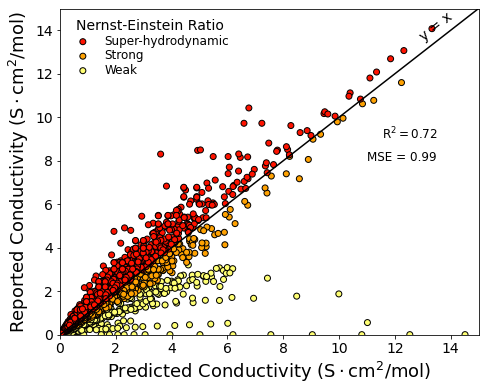

In [4]:
# Plotting Nernst-Einstein predictions vs experimentally reported conductivity data. Colored according to electorlyte behavior as described by Nernst-Einstein Ratio

fig,ax1=plt.subplots(1,figsize=(7.5,6), facecolor='white')
ax1.grid(color='gray',axis='both',alpha=0)
ax1.set_axisbelow(True)

ax1.tick_params(left=True, bottom=True, labelleft = True, labelbottom=True, labelsize=14)
ax1.set_facecolor('none')

colors = {0:'white', 1:'#ffff74',2:'#ffa202',3:'#ff1300'}

plt.scatter(NE_data.loc[NE_data['NE_ratio_cat'] == 1]['SimNernstEinstein_Scm2_mol'], NE_data.loc[NE_data['NE_ratio_cat'] == 1]['molarCond_Scm2mol'], c=NE_data.loc[NE_data['NE_ratio_cat'] == 1]['NE_ratio_cat'].map(colors), marker='o', label = "Weak", edgecolors='black')
plt.scatter(NE_data.loc[NE_data['NE_ratio_cat'] == 2]['SimNernstEinstein_Scm2_mol'], NE_data.loc[NE_data['NE_ratio_cat'] == 2]['molarCond_Scm2mol'], c=NE_data.loc[NE_data['NE_ratio_cat'] == 2]['NE_ratio_cat'].map(colors), marker='o', label = "Strong", edgecolors='black')
plt.scatter(NE_data.loc[NE_data['NE_ratio_cat'] == 3]['SimNernstEinstein_Scm2_mol'], NE_data.loc[NE_data['NE_ratio_cat'] == 3]['molarCond_Scm2mol'], c=NE_data.loc[NE_data['NE_ratio_cat'] == 3]['NE_ratio_cat'].map(colors), marker='o', label = "Super-hydrodynamic", edgecolors='black')
plt.plot([0,15],[0,15], color = 'black')

ax1.set_xlim(0,15)
ax1.set_ylim(0,15)

ax1Pos = ax1.get_position()
ax1Pos.x0 = ax1Pos.x0 + 0.02
ax1Pos.x1 = ax1Pos.x1 + 0.02
ax1.set_position(ax1Pos)

handles, labels = ax1.get_legend_handles_labels()

ax1.legend(reversed(handles), reversed(labels), title='Nernst-Einstein Ratio', loc=2, markerscale=1, labelspacing=0.125, ncol=1, columnspacing= 0, edgecolor='none', fontsize=12, title_fontsize=14, facecolor='none')

plt.annotate('$\mathregular{R^{2}=}$'+str(np.round(r2_score(NE_data['molarCond_Scm2mol'], NE_data['SimNernstEinstein_Scm2_mol']),2)), (11.53,9), fontsize=12)
plt.annotate('MSE = '+str(np.round(mean_squared_error(NE_data['molarCond_Scm2mol'], NE_data['SimNernstEinstein_Scm2_mol']),2)), (11,8), fontsize=12)

ax1.set_xlabel('Predicted Conductivity ($\mathregular{S \cdot cm^{2} / mol}$)', fontsize=18)
ax1.set_ylabel('Reported Conductivity ($\mathregular{S \cdot cm^{2} / mol}$)', fontsize=18)

plt.annotate('y = x ', (12.8,13.5), rotation=38.6, fontsize=14)

# Hybrid Nernst-Einstein

Text(12.8, 13.5, 'y = x ')

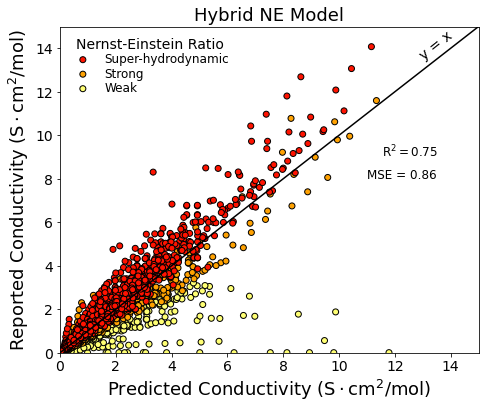

In [5]:
# Training a random forest model to predict residual conductivity using Nernst-Einstein inputs

gss = GroupKFold(n_splits=5)

NE_scaler = StandardScaler()

scaled_NE_variables = pd.DataFrame(NE_scaler.fit_transform(Data_dropna[['Sim_rCation', 'Sim_rAnion', 'Viscosity']]), columns=(Data_dropna[['Sim_rCation', 'Sim_rAnion', 'Viscosity']].columns))

DV1 = 'molarCond_Scm2mol'
DV2 = 'residualCond'
DV3 = 'SimNernstEinstein_Scm2_mol'

forest_unique = RandomForestRegressor(random_state=0)

count_2 = 0
testY_ind_arr = [[],[],[],[],[]]
testY_arr = [[],[],[],[],[]]
forest_unique_predictions_arr = [[],[],[],[],[]]

for train_ind, test_ind in gss.split(scaled_NE_variables, Scaled_Cond_Data, Cond_data['compString']): # Split data into training and test splits for 5-fold cross validation
    trainingX        = scaled_NE_variables.iloc[train_ind,:]
    testX            = scaled_NE_variables.iloc[test_ind,:]
    trainingY        = Scaled_Cond_Data.iloc[train_ind,:]
    testY_arr[count_2] = Scaled_Cond_Data.iloc[test_ind,:]

    testY_ind_arr[count_2] = test_ind

    forest_unique.fit(trainingX, trainingY[DV2]) # Training

    forest_unique_predictions_arr[count_2] = forest_unique.predict(testX) # Testing

    count_2 = count_2 + 1
    
    # Calculating performance metrics

RF_full_pred = np.concatenate((forest_unique_predictions_arr[0], forest_unique_predictions_arr[1], forest_unique_predictions_arr[2], forest_unique_predictions_arr[3], forest_unique_predictions_arr[4]))


testY_full_Res = ScaleY.inverse_transform(np.concatenate((testY_arr[0][DV2], testY_arr[1][DV2], testY_arr[2][DV2], testY_arr[3][DV2], testY_arr[4][DV2]), axis=0).reshape(-1,1)).reshape(Scaled_Cond_Data.shape[0],)
testY_full_Cond = ScaleY.inverse_transform(np.concatenate((testY_arr[0][DV1], testY_arr[1][DV1], testY_arr[2][DV1], testY_arr[3][DV1], testY_arr[4][DV1]), axis=0).reshape(-1,1)).reshape(Scaled_Cond_Data.shape[0],)
testY_full_NE = ScaleY.inverse_transform(np.concatenate((testY_arr[0][DV3], testY_arr[1][DV3], testY_arr[2][DV3], testY_arr[3][DV3], testY_arr[4][DV3]), axis=0).reshape(-1,1)).reshape(Scaled_Cond_Data.shape[0],)

testY_ind_full = ScaleY.inverse_transform(np.concatenate((testY_ind_arr[0], testY_ind_arr[1], testY_ind_arr[2], testY_ind_arr[3], testY_ind_arr[4]), axis=0).reshape(-1,1)).reshape(Scaled_Cond_Data.shape[0],)

forest_feature_r2 = r2_score(testY_full_Res, RF_full_pred)
forest_feature_mse = metrics.mean_squared_error(testY_full_Res, RF_full_pred)

Full_forest_feature_r2 = r2_score(testY_full_Cond, RF_full_pred + testY_full_NE)
Full_forest_feature_mse = metrics.mean_squared_error(testY_full_Cond, (RF_full_pred + testY_full_NE))     

NE_Cat_RF = testY_full_Cond / testY_full_NE 

NE_cat = [0] * NE_Cat_RF.shape[0] # Categorize data as super-hydrodynamic, strong, or weak electrolyte behaviors
count = 0
for i in NE_Cat_RF:
    if i > 1:
        NE_cat[count] = 3
    elif i >= 0.7:
        NE_cat[count] = 2
    elif i >= 0:
        NE_cat[count] = 1
    else:
        NE_cat[count] = 0
    count = count + 1

RF_Hybrid_df = pd.DataFrame(data={'RF Res Pred':RF_full_pred, 'Full Cond Pred':RF_full_pred+testY_full_NE, 'NE': testY_full_NE, 'Res': testY_full_Res, 'Cond': testY_full_Cond, 'NE Cat': NE_cat})

# Plotting Nernst-Einstein predictions vs experimentally reported conductivity data. Colored according to electorlyte behavior as described by Nernst-Einstein Ratio

fig,ax1=plt.subplots(1,figsize=(7.5,6), facecolor='White')
ax1.grid(color='gray',axis='both',alpha=0)
ax1.set_axisbelow(True)

ax1.tick_params(left=True, bottom=True, labelleft = True, labelbottom=True, labelsize=14)
ax1.set_facecolor('none')

colors = {0:'white', 1:'#ffff74',2:'#ffa202',3:'#ff1300'}

plt.scatter(RF_Hybrid_df.loc[RF_Hybrid_df['NE Cat'] == 1]['Full Cond Pred'], RF_Hybrid_df.loc[RF_Hybrid_df['NE Cat'] == 1]['Cond'], c=RF_Hybrid_df.loc[RF_Hybrid_df['NE Cat'] == 1]['NE Cat'].map(colors), marker='o', label = "Weak", edgecolors='black')
plt.scatter(RF_Hybrid_df.loc[RF_Hybrid_df['NE Cat'] == 2]['Full Cond Pred'], RF_Hybrid_df.loc[RF_Hybrid_df['NE Cat'] == 2]['Cond'], c=RF_Hybrid_df.loc[RF_Hybrid_df['NE Cat'] == 2]['NE Cat'].map(colors), marker='o', label = "Strong", edgecolors='black')
plt.scatter(RF_Hybrid_df.loc[RF_Hybrid_df['NE Cat'] == 3]['Full Cond Pred'], RF_Hybrid_df.loc[RF_Hybrid_df['NE Cat'] == 3]['Cond'], c=RF_Hybrid_df.loc[RF_Hybrid_df['NE Cat'] == 3]['NE Cat'].map(colors), marker='o', label = "Super-hydrodynamic", edgecolors='black')
plt.plot([0,15],[0,15], color = 'black')

ax1.set_xlim(0,15)
ax1.set_ylim(0,15)

ax1Pos = ax1.get_position()
ax1Pos.x0 = ax1Pos.x0 + 0.02
ax1Pos.x1 = ax1Pos.x1 + 0.02
ax1.set_position(ax1Pos)

handles, labels = ax1.get_legend_handles_labels()

ax1.legend(reversed(handles), reversed(labels), title='Nernst-Einstein Ratio', loc=2, markerscale=1, labelspacing=0.125, ncol=1, columnspacing= 0, edgecolor='none', fontsize=12, title_fontsize=14, facecolor='none')

plt.annotate('$\mathregular{R^{2}=}$'+str(np.round(r2_score(RF_Hybrid_df['Cond'], RF_Hybrid_df['Full Cond Pred']),2)), (11.53,9), fontsize=12)
plt.annotate('MSE = '+str(np.round(mean_squared_error(RF_Hybrid_df['Cond'], RF_Hybrid_df['Full Cond Pred']),2)), (11,8), fontsize=12)

ax1.set_title('Hybrid NE Model', fontsize=18)
ax1.set_xlabel('Predicted Conductivity ($\mathregular{S \cdot cm^{2} / mol}$)', fontsize=18)
ax1.set_ylabel('Reported Conductivity ($\mathregular{S \cdot cm^{2} / mol}$)', fontsize=18)

plt.annotate('y = x ', (12.8,13.5), rotation=38.6, fontsize=14)

# Greedy Algorithm Feature Selection Loop

/var/folders/n0/8fxhskld1wsc76dqzmh0f_9w0000gn/T/ipykernel_87896/1411544676.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data_dropna['Zeros'] = np.zeros(2224)


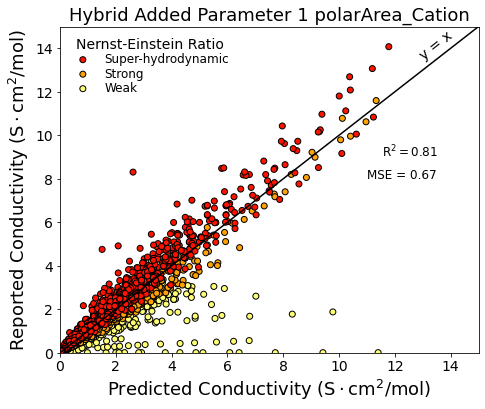

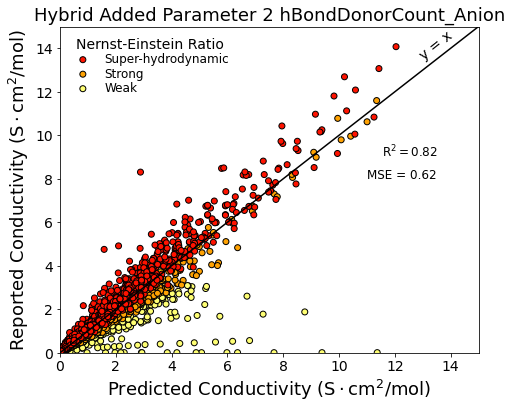

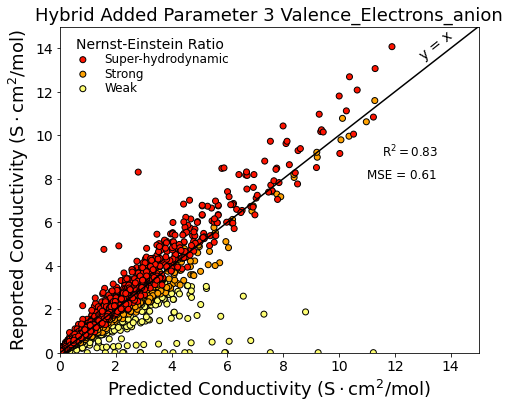

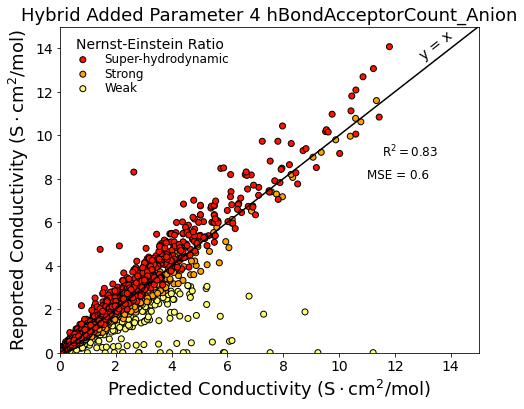

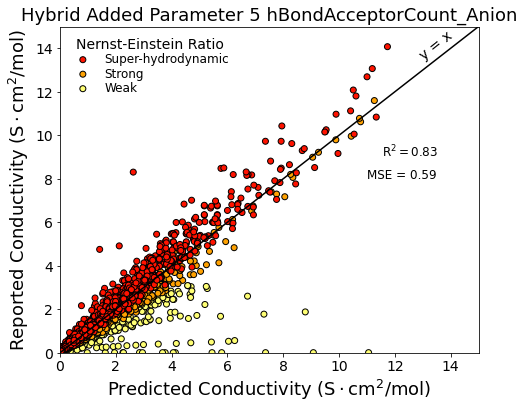

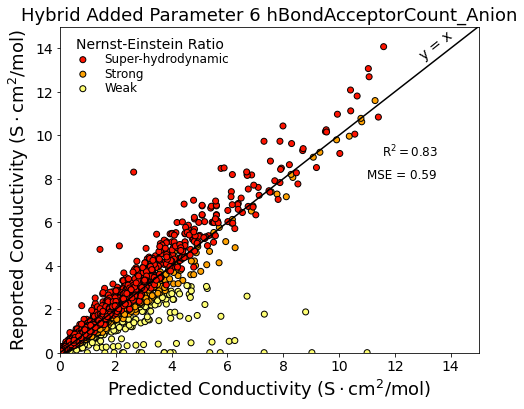

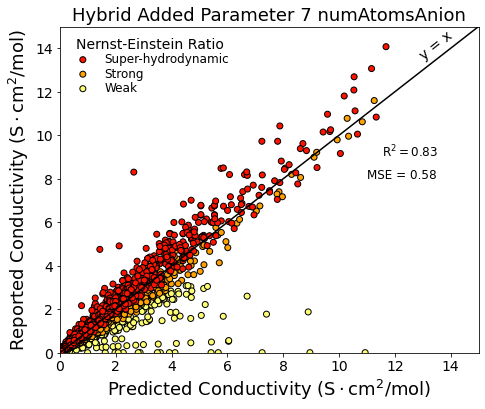

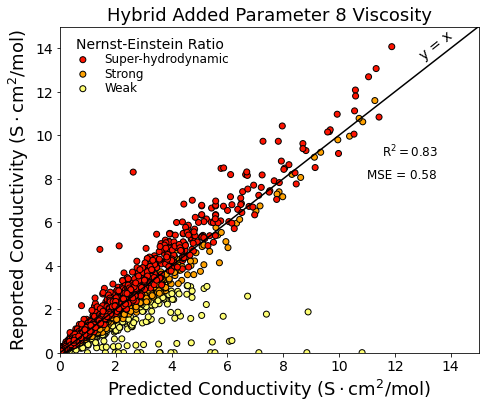

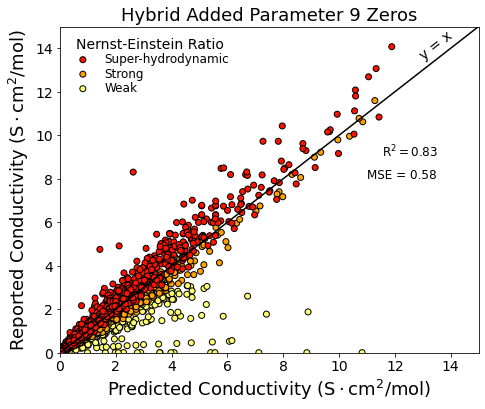

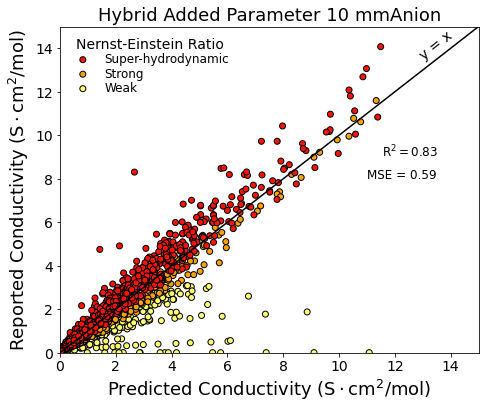

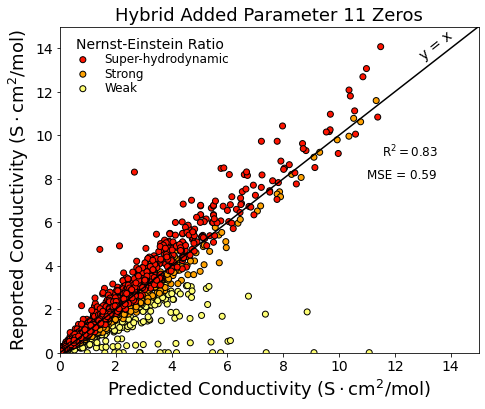

In [6]:
# Training a random forest model to predict residual conductivity using Nernst-Einstein inputs and additional descriptors iteratively chosen using a greedy selection algorithm.
# This will select the best inputs for predicting non-hydrodynamic contributions to conductivity

gss = GroupKFold(n_splits=5)

Add_one_scaler = StandardScaler()
NE_scaler = StandardScaler()

Data_dropna['Zeros'] = np.zeros(2224)

improve = 0.0
counter = 0

Best_feature = []
feature_MSE = []
feature_R2 = []
Full_feature_MSE = []
Full_feature_R2 = []

while improve >= 0: # Will continue to select more inputs until the model MSE worsens

    # Checking for model improvement
    
    if len(feature_MSE) > 1:
        improve = Full_feature_MSE[-2] - Full_feature_MSE[-1]
    else:
        improve = 0

    scaled_data = pd.DataFrame(Add_one_scaler.fit_transform(Data_dropna.drop(['molarCond_Scm2mol', 'compString', 'SimNernstEinstein_Scm2_mol', 'Smiles_cation', 'Smiles_anion', 'residualCond', 'NE Ratio', 'Electrical_conductivity'], axis=1)), columns=(Data_dropna.drop(['molarCond_Scm2mol', 'compString', 'SimNernstEinstein_Scm2_mol', 'Smiles_cation', 'Smiles_anion', 'residualCond', 'NE Ratio', 'Electrical_conductivity'], axis=1)).columns)
    scaled_NE_variables = pd.DataFrame(NE_scaler.fit_transform(Data_dropna[['Sim_rCation', 'Sim_rAnion', 'Viscosity'] + Best_feature]), columns=(Data_dropna[['Sim_rCation', 'Sim_rAnion', 'Viscosity'] + Best_feature].columns))

    DV1 = 'molarCond_Scm2mol'
    DV2 = 'residualCond'
    DV3 = 'SimNernstEinstein_Scm2_mol'

    # Creating variables to store performance metrics during training for greedy selection algorithm

    count_1 = 0
    missing_feature = ['none']*scaled_data.shape[1]
    forest_feature_r2 = [0.0]*scaled_data.shape[1]
    forest_feature_mse = [0.0]*scaled_data.shape[1]
    Full_forest_feature_r2 = [0.0]*scaled_data.shape[1]
    Full_forest_feature_mse = [0.0]*scaled_data.shape[1]

    RF_full_pred = [[0.0]*scaled_data.shape[0]]*scaled_data.shape[1]
    RF_Full_cond_pred = [[0.0]*scaled_data.shape[0]]*scaled_data.shape[1]
    testY_full_NE = [[0.0]*scaled_data.shape[0]]*scaled_data.shape[1]
    testY_full_Res = [[0.0]*scaled_data.shape[0]]*scaled_data.shape[1]
    testY_full_Cond = [[0.0]*scaled_data.shape[0]]*scaled_data.shape[1]

    for i in scaled_data: # Loops over all possible descriptors for the random forest model to add to the training input

        missing_feature[count_1] = i

        forest_unique = RandomForestRegressor(random_state=0)

        Temp_data = pd.concat((scaled_NE_variables, scaled_data[[i]]), axis='columns') # selecting current variables and adding 1 additional input

        if i == 'Zeros': # Creates an input of all Zeros to have a basis for comparison against other descriptors
            Temp_data = scaled_NE_variables

        count_2 = 0
        testY_ind_arr = [[],[],[],[],[]]
        testY_arr = [[],[],[],[],[]]
        forest_unique_predictions_arr = [[],[],[],[],[]]


        for train_ind, test_ind in gss.split(Temp_data, Scaled_Cond_Data, Cond_data['compString']): # Split data into training and test splits for 5-fold cross validation
            trainingX        = Temp_data.iloc[train_ind,:]
            testX            = Temp_data.iloc[test_ind,:]
            trainingY        = Scaled_Cond_Data.iloc[train_ind,:]
            testY_arr[count_2] = Scaled_Cond_Data.iloc[test_ind,:]

            testY_ind_arr[count_2] = test_ind

            forest_unique.fit(trainingX, trainingY[DV2]) # Training

            forest_unique_predictions_arr[count_2] = forest_unique.predict(testX) # Testing

            count_2 = count_2 + 1
        
        # Calculating performance metrics for each available descriptor
    
        RF_full_pred[count_1] = np.concatenate((forest_unique_predictions_arr[0], forest_unique_predictions_arr[1], forest_unique_predictions_arr[2], forest_unique_predictions_arr[3], forest_unique_predictions_arr[4]))

        
        testY_full_Res[count_1] = ScaleY.inverse_transform(np.concatenate((testY_arr[0][DV2], testY_arr[1][DV2], testY_arr[2][DV2], testY_arr[3][DV2], testY_arr[4][DV2]), axis=0).reshape(-1,1)).reshape(Scaled_Cond_Data.shape[0],)
        testY_full_Cond[count_1] = ScaleY.inverse_transform(np.concatenate((testY_arr[0][DV1], testY_arr[1][DV1], testY_arr[2][DV1], testY_arr[3][DV1], testY_arr[4][DV1]), axis=0).reshape(-1,1)).reshape(Scaled_Cond_Data.shape[0],)
        testY_full_NE[count_1] = ScaleY.inverse_transform(np.concatenate((testY_arr[0][DV3], testY_arr[1][DV3], testY_arr[2][DV3], testY_arr[3][DV3], testY_arr[4][DV3]), axis=0).reshape(-1,1)).reshape(Scaled_Cond_Data.shape[0],)

        RF_Full_cond_pred[count_1] = RF_full_pred[count_1] + testY_full_NE[count_1]

        testY_ind_full = ScaleY.inverse_transform(np.concatenate((testY_ind_arr[0], testY_ind_arr[1], testY_ind_arr[2], testY_ind_arr[3], testY_ind_arr[4]), axis=0).reshape(-1,1)).reshape(Scaled_Cond_Data.shape[0],)

        forest_feature_r2[count_1] = r2_score(testY_full_Res[count_1], RF_full_pred[count_1])
        forest_feature_mse[count_1] = metrics.mean_squared_error(testY_full_Res[count_1], RF_full_pred[count_1])

        Full_forest_feature_r2[count_1] = r2_score(testY_full_Cond[count_1], RF_full_pred[count_1] + testY_full_NE[count_1])
        Full_forest_feature_mse[count_1] = metrics.mean_squared_error(testY_full_Cond[count_1], (RF_full_pred[count_1] + testY_full_NE[count_1]))     

        count_1 = count_1+1

    # Selecting the additional descriptor which resulted in the lowest MSE

    dat = {'Missing Parameter': missing_feature, 'Forest R^2': forest_feature_r2, 'Forest MSE': forest_feature_mse, 'Full Forest R^2': Full_forest_feature_r2, 'Full Forest MSE': Full_forest_feature_mse, 'Full Pred': RF_Full_cond_pred, 'Cond': testY_full_Cond, 'NE': testY_full_NE}
    data_frame_sort = pd.DataFrame(data=dat).sort_values(by='Full Forest MSE', ascending=True)

    Best_feature.append(data_frame_sort.iloc[0,0])
    feature_R2.append(data_frame_sort.iloc[0,1])
    feature_MSE.append(data_frame_sort.iloc[0,2])
    Full_feature_R2.append(data_frame_sort.iloc[0,3])
    Full_feature_MSE.append(data_frame_sort.iloc[0,4])

    NE_Cat_RF = data_frame_sort.iloc[0,6] / data_frame_sort.iloc[0,7] 

    NE_cat = [0] * NE_Cat_RF.shape[0] # Categorize data as super-hydrodynamic, strong, or weak electrolyte behaviors
    count = 0
    for i in NE_Cat_RF:
        if i > 1:
            NE_cat[count] = 3
        elif i >= 0.7:
            NE_cat[count] = 2
        elif i >= 0:
            NE_cat[count] = 1
        else:
            NE_cat[count] = 0
        count = count + 1

    RF_Hybrid_df = pd.DataFrame(data={'Full Cond Pred':data_frame_sort.iloc[0,5], 'NE': data_frame_sort.iloc[0,7], 'Cond': data_frame_sort.iloc[0,6], 'NE Cat': NE_cat})

    # Plotting Nernst-Einstein predictions vs experimentally reported conductivity data. Colored according to electorlyte behavior as described by Nernst-Einstein Ratio

    fig,ax1=plt.subplots(1,figsize=(7.5,6), facecolor='White')
    ax1.grid(color='gray',axis='both',alpha=0)
    ax1.set_axisbelow(True)

    ax1.tick_params(left=True, bottom=True, labelleft = True, labelbottom=True, labelsize=14)
    ax1.set_facecolor('none')

    colors = {0:'white', 1:'#ffff74',2:'#ffa202',3:'#ff1300'}

    plt.scatter(RF_Hybrid_df.loc[RF_Hybrid_df['NE Cat'] == 1]['Full Cond Pred'], RF_Hybrid_df.loc[RF_Hybrid_df['NE Cat'] == 1]['Cond'], c=RF_Hybrid_df.loc[RF_Hybrid_df['NE Cat'] == 1]['NE Cat'].map(colors), marker='o', label = "Weak", edgecolors='black')
    plt.scatter(RF_Hybrid_df.loc[RF_Hybrid_df['NE Cat'] == 2]['Full Cond Pred'], RF_Hybrid_df.loc[RF_Hybrid_df['NE Cat'] == 2]['Cond'], c=RF_Hybrid_df.loc[RF_Hybrid_df['NE Cat'] == 2]['NE Cat'].map(colors), marker='o', label = "Strong", edgecolors='black')
    plt.scatter(RF_Hybrid_df.loc[RF_Hybrid_df['NE Cat'] == 3]['Full Cond Pred'], RF_Hybrid_df.loc[RF_Hybrid_df['NE Cat'] == 3]['Cond'], c=RF_Hybrid_df.loc[RF_Hybrid_df['NE Cat'] == 3]['NE Cat'].map(colors), marker='o', label = "Super-hydrodynamic", edgecolors='black')
    plt.plot([0,15],[0,15], color = 'black')

    ax1.set_xlim(0,15)
    ax1.set_ylim(0,15)

    ax1Pos = ax1.get_position()
    ax1Pos.x0 = ax1Pos.x0 + 0.02
    ax1Pos.x1 = ax1Pos.x1 + 0.02
    ax1.set_position(ax1Pos)

    handles, labels = ax1.get_legend_handles_labels()

    ax1.legend(reversed(handles), reversed(labels), title='Nernst-Einstein Ratio', loc=2, markerscale=1, labelspacing=0.125, ncol=1, columnspacing= 0, edgecolor='none', fontsize=12, title_fontsize=14, facecolor='none')

    plt.annotate('$\mathregular{R^{2}=}$'+str(np.round(r2_score(RF_Hybrid_df['Cond'], RF_Hybrid_df['Full Cond Pred']),2)), (11.53,9), fontsize=12)
    plt.annotate('MSE = '+str(np.round(mean_squared_error(RF_Hybrid_df['Cond'], RF_Hybrid_df['Full Cond Pred']),2)), (11,8), fontsize=12)

    ax1.set_title('Hybrid Added Parameter ' + str(counter + 1) + ' ' + data_frame_sort.iloc[0,0], fontsize=18)
    ax1.set_xlabel('Predicted Conductivity ($\mathregular{S \cdot cm^{2} / mol}$)', fontsize=18)
    ax1.set_ylabel('Reported Conductivity ($\mathregular{S \cdot cm^{2} / mol}$)', fontsize=18)

    plt.annotate('y = x ', (12.8,13.5), rotation=38.6, fontsize=14)

    counter = counter + 1

# Results

In [7]:
# Printing results
Results = pd.DataFrame(data={'Rank' : np.arange(1,len(Best_feature)+1,1), 'Feature' : Best_feature,  'Conducivity R^2' : Full_feature_R2, 'Conducivity MSE' : Full_feature_MSE, 'Residual Conducivity R^2' : feature_R2, 'Residual Conducivity MSE' : feature_MSE})
Results

,Rank,Feature,Conducivity R^2,Conducivity MSE,Residual Conducivity R^2,Residual Conducivity MSE
0,1,polarArea_Cation,0.807404,0.671665,-3.161318,4.105424
1,2,hBondDonorCount_Anion,0.821557,0.622309,-3.140197,4.084586
2,3,Valence_Electrons_anion,0.825650,0.608036,-3.130532,4.075051
3,4,hBondAcceptorCount_Anion,0.827789,0.600575,-3.149471,4.093736
4,5,hBondAcceptorCount_Anion,0.831407,0.587957,-3.135746,4.080195
5,6,hBondAcceptorCount_Anion,0.831583,0.587345,-3.137772,4.082194
6,7,numAtomsAnion,0.832471,0.584246,-3.131011,4.075524
7,8,Viscosity,0.833831,0.579502,-3.118203,4.062888
8,9,Zeros,0.833831,0.579502,-3.118203,4.062888
9,10,mmAnion,0.830993,0.589400,-3.138691,4.083101


# All Variables

Text(12.8, 13.5, 'y = x ')

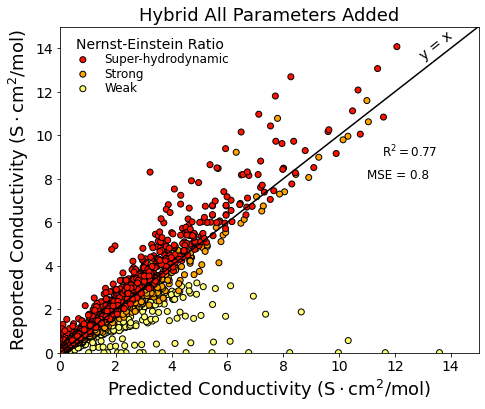

In [8]:
# Training a random forest model to predict residual conductivity using Nernst-Einstein inputs

gss = GroupKFold(n_splits=5)

NE_scaler = StandardScaler()

scaled_data = pd.DataFrame(Add_one_scaler.fit_transform(Data_dropna.drop(['molarCond_Scm2mol', 'compString', 'SimNernstEinstein_Scm2_mol', 'Smiles_cation', 'Smiles_anion', 'residualCond', 'NE Ratio', 'Electrical_conductivity'], axis=1)), columns=(Data_dropna.drop(['molarCond_Scm2mol', 'compString', 'SimNernstEinstein_Scm2_mol', 'Smiles_cation', 'Smiles_anion', 'residualCond', 'NE Ratio', 'Electrical_conductivity'], axis=1)).columns)

DV1 = 'molarCond_Scm2mol'
DV2 = 'residualCond'
DV3 = 'SimNernstEinstein_Scm2_mol'

forest_unique = RandomForestRegressor(random_state=0)

count_2 = 0
testY_ind_arr = [[],[],[],[],[]]
testY_arr = [[],[],[],[],[]]
forest_unique_predictions_arr = [[],[],[],[],[]]

for train_ind, test_ind in gss.split(scaled_data, Scaled_Cond_Data, Cond_data['compString']): # Split data into training and test splits for 5-fold cross validation
    trainingX        = scaled_data.iloc[train_ind,:]
    testX            = scaled_data.iloc[test_ind,:]
    trainingY        = Scaled_Cond_Data.iloc[train_ind,:]
    testY_arr[count_2] = Scaled_Cond_Data.iloc[test_ind,:]

    testY_ind_arr[count_2] = test_ind

    forest_unique.fit(trainingX, trainingY[DV2]) # Training

    forest_unique_predictions_arr[count_2] = forest_unique.predict(testX) # Testing

    count_2 = count_2 + 1
    
    # Calculating performance metrics

RF_full_pred = np.concatenate((forest_unique_predictions_arr[0], forest_unique_predictions_arr[1], forest_unique_predictions_arr[2], forest_unique_predictions_arr[3], forest_unique_predictions_arr[4]))


testY_full_Res = ScaleY.inverse_transform(np.concatenate((testY_arr[0][DV2], testY_arr[1][DV2], testY_arr[2][DV2], testY_arr[3][DV2], testY_arr[4][DV2]), axis=0).reshape(-1,1)).reshape(Scaled_Cond_Data.shape[0],)
testY_full_Cond = ScaleY.inverse_transform(np.concatenate((testY_arr[0][DV1], testY_arr[1][DV1], testY_arr[2][DV1], testY_arr[3][DV1], testY_arr[4][DV1]), axis=0).reshape(-1,1)).reshape(Scaled_Cond_Data.shape[0],)
testY_full_NE = ScaleY.inverse_transform(np.concatenate((testY_arr[0][DV3], testY_arr[1][DV3], testY_arr[2][DV3], testY_arr[3][DV3], testY_arr[4][DV3]), axis=0).reshape(-1,1)).reshape(Scaled_Cond_Data.shape[0],)

testY_ind_full = ScaleY.inverse_transform(np.concatenate((testY_ind_arr[0], testY_ind_arr[1], testY_ind_arr[2], testY_ind_arr[3], testY_ind_arr[4]), axis=0).reshape(-1,1)).reshape(Scaled_Cond_Data.shape[0],)

forest_feature_r2 = r2_score(testY_full_Res, RF_full_pred)
forest_feature_mse = metrics.mean_squared_error(testY_full_Res, RF_full_pred)

Full_forest_feature_r2 = r2_score(testY_full_Cond, RF_full_pred + testY_full_NE)
Full_forest_feature_mse = metrics.mean_squared_error(testY_full_Cond, (RF_full_pred + testY_full_NE))     

NE_Cat_RF = testY_full_Cond / testY_full_NE 

NE_cat = [0] * NE_Cat_RF.shape[0] # Categorize data as super-hydrodynamic, strong, or weak electrolyte behaviors
count = 0
for i in NE_Cat_RF:
    if i > 1:
        NE_cat[count] = 3
    elif i >= 0.7:
        NE_cat[count] = 2
    elif i >= 0:
        NE_cat[count] = 1
    else:
        NE_cat[count] = 0
    count = count + 1

RF_Hybrid_df = pd.DataFrame(data={'RF Res Pred':RF_full_pred, 'Full Cond Pred':RF_full_pred+testY_full_NE, 'NE': testY_full_NE, 'Res': testY_full_Res, 'Cond': testY_full_Cond, 'NE Cat': NE_cat})

# Plotting Nernst-Einstein predictions vs experimentally reported conductivity data. Colored according to electorlyte behavior as described by Nernst-Einstein Ratio

fig,ax1=plt.subplots(1,figsize=(7.5,6), facecolor='White')
ax1.grid(color='gray',axis='both',alpha=0)
ax1.set_axisbelow(True)

ax1.tick_params(left=True, bottom=True, labelleft = True, labelbottom=True, labelsize=14)
ax1.set_facecolor('none')

colors = {0:'white', 1:'#ffff74',2:'#ffa202',3:'#ff1300'}

plt.scatter(RF_Hybrid_df.loc[RF_Hybrid_df['NE Cat'] == 1]['Full Cond Pred'], RF_Hybrid_df.loc[RF_Hybrid_df['NE Cat'] == 1]['Cond'], c=RF_Hybrid_df.loc[RF_Hybrid_df['NE Cat'] == 1]['NE Cat'].map(colors), marker='o', label = "Weak", edgecolors='black')
plt.scatter(RF_Hybrid_df.loc[RF_Hybrid_df['NE Cat'] == 2]['Full Cond Pred'], RF_Hybrid_df.loc[RF_Hybrid_df['NE Cat'] == 2]['Cond'], c=RF_Hybrid_df.loc[RF_Hybrid_df['NE Cat'] == 2]['NE Cat'].map(colors), marker='o', label = "Strong", edgecolors='black')
plt.scatter(RF_Hybrid_df.loc[RF_Hybrid_df['NE Cat'] == 3]['Full Cond Pred'], RF_Hybrid_df.loc[RF_Hybrid_df['NE Cat'] == 3]['Cond'], c=RF_Hybrid_df.loc[RF_Hybrid_df['NE Cat'] == 3]['NE Cat'].map(colors), marker='o', label = "Super-hydrodynamic", edgecolors='black')
plt.plot([0,15],[0,15], color = 'black')

ax1.set_xlim(0,15)
ax1.set_ylim(0,15)

ax1Pos = ax1.get_position()
ax1Pos.x0 = ax1Pos.x0 + 0.02
ax1Pos.x1 = ax1Pos.x1 + 0.02
ax1.set_position(ax1Pos)

handles, labels = ax1.get_legend_handles_labels()

ax1.legend(reversed(handles), reversed(labels), title='Nernst-Einstein Ratio', loc=2, markerscale=1, labelspacing=0.125, ncol=1, columnspacing= 0, edgecolor='none', fontsize=12, title_fontsize=14, facecolor='none')

plt.annotate('$\mathregular{R^{2}=}$'+str(np.round(r2_score(RF_Hybrid_df['Cond'], RF_Hybrid_df['Full Cond Pred']),2)), (11.53,9), fontsize=12)
plt.annotate('MSE = '+str(np.round(mean_squared_error(RF_Hybrid_df['Cond'], RF_Hybrid_df['Full Cond Pred']),2)), (11,8), fontsize=12)

ax1.set_title('Hybrid All Parameters Added', fontsize=18)
ax1.set_xlabel('Predicted Conductivity ($\mathregular{S \cdot cm^{2} / mol}$)', fontsize=18)
ax1.set_ylabel('Reported Conductivity ($\mathregular{S \cdot cm^{2} / mol}$)', fontsize=18)

plt.annotate('y = x ', (12.8,13.5), rotation=38.6, fontsize=14)